<div class="namebox">    
Double Click to edit and enter your

1.  Judy Truong
2.  A17298535
3.  jut008@ucsd.edu
    
</div>

,index,threads,size,arg1,IC,CPI,CT,ET,L1_dcache_miss_rate
0,0,1,4096,8,342656038,0.833117,0.386514,0.110339,0.000041
1,1,2,4096,8,688180658,0.836418,0.198839,0.114453,0.000072
2,2,3,4096,8,1030545546,0.804833,0.143426,0.118960,0.000063
3,3,4,4096,8,1373591688,0.807342,0.108662,0.120502,0.000068


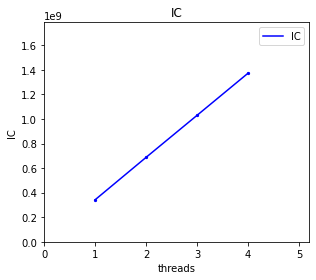

In [8]:
#key data_cell display_mono(render_csv("threads.csv", columns=["threads",\ 
"size", "arg1", "IC", "CPI", "CT", "ET", "L1_dcache_miss_rate"]))\ 
plotPE("threads.csv", lines=True, what=[("threads", "IC")])

<div class="alert alert-block alert-success">

### Question 1 (CSE142 & CSE142L)

With 4 threads how many total instructions were executed? **Please discussion why the observed number makes sense in addition to your measurement results**.

</div>

<div class="alert alert-block alert-success">

**Total IC:** 1,373,591,688

**Why this make sense?**

With 4 threads the total number of instructions executed is 1,373,591,688. This matches expectations since with 1 thread we measured 342,656,038 instructions and multiplying by 4 gives about 1,370,624,152. The small difference comes from overhead like creating and joining threads. The CPI stays consistent across runs from 0.804833 to 0.836418 and execution time only changes slightly from 0.110339 seconds with 1 thread to 0.120502 seconds with 4 threads, showing that each thread did the same amount of work and the instruction count scales as expected.

</div>

<div class="alert alert-block alert-warning">

### Question 2 (CSE142L Only)



In the above code, will the `std::cerr` line ever execute?  Why or why not? 
    
Please clearly state your answer and provide explainations. You need to give good enough reasons for question to receive credits.


</div>

<div class="alert alert-block alert-warning">

Answer: Yes, the std::cerr line can execute. flag and other_value are volatile but not atomic, so there is no happens-before relationship between the threads. A writer does other_value = my_id then flag = my_id. The reader spins until flag == other_id, then immediately loads flag and other_value. On a weakly ordered CPU, the reader can observe the newer flag but a stale other_value, so t_flag != t_other_value becomes true and the mismatch prints. volatile only stops some compiler optimizations on the single thread. It does not give inter-thread synchronization, ordering, or atomicity. The correct fix is to use std::atomic&lt;int&gt; with release on the writes to other_value and flag and acquire on the reads in wait, or use a mutex or condition variable.
</div>

<div class="alert alert-block alert-warning">

### Question 3 (CSE142L Only)



Based on the assembly above, and assuming multiple threads are running at once, explain how `shared` ends up being computed incorrectly without locks and how adding locks prevents it. Please provide explainations. You need to give good enough reasons to receive credits.
  

</div>

<div class="alert alert-block alert-warning">    

Answer:  Without locks, each shared++ compiles to a load–add–store sequence:

movl shared(%rip), %eax

addl $1, %eax

movl %eax, shared(%rip)

This is a read-modify-write that is not atomic. With multiple threads, two cores can both load the same old value of shared from their caches, both add 1, and then each store back, so one increment is lost. This is the classic data race and lost-update problem. Cache coherence does not fix it because coherence preserves visibility of writes, not the atomicity of the whole read-modify-write. Reorderings via store buffers can also let one thread observe stale values while another’s write is still pending.

Adding std::mutex turns the increment into a critical section protected by lock.lock() and lock.unlock(). The mutex operations are implemented with atomic instructions and memory fences that provide acquire–release semantics and a happens-before relationship. Only one thread can execute the load–add–store at a time, so no two threads can read the same old value, and every increment counts, yielding the correct final shared value. Also note that volatile int shared does not provide atomicity or ordering between threads; it only restricts compiler optimizations within one thread.


</div>


,threads,locks,IC per increment,CPI,ET,Cycles per increment,L1 Misses Per Increment
0,1,1,59.035840,0.651233,0.883184,38.446084,0.000200
1,1,0,5.100183,0.727584,0.090571,3.710813,0.000127
2,2,1,205.827132,1.932698,2.301912,397.801631,0.578075
3,2,0,10.103464,0.982248,0.066927,9.924103,0.042843
4,3,1,339.500039,2.189661,2.014297,743.390055,1.192339
5,3,0,15.256520,1.147435,0.053335,17.505869,0.051168
6,4,1,545.190450,2.721937,2.521472,1483.974243,2.942781
7,4,0,19.676543,1.229945,0.045336,24.201076,0.062926


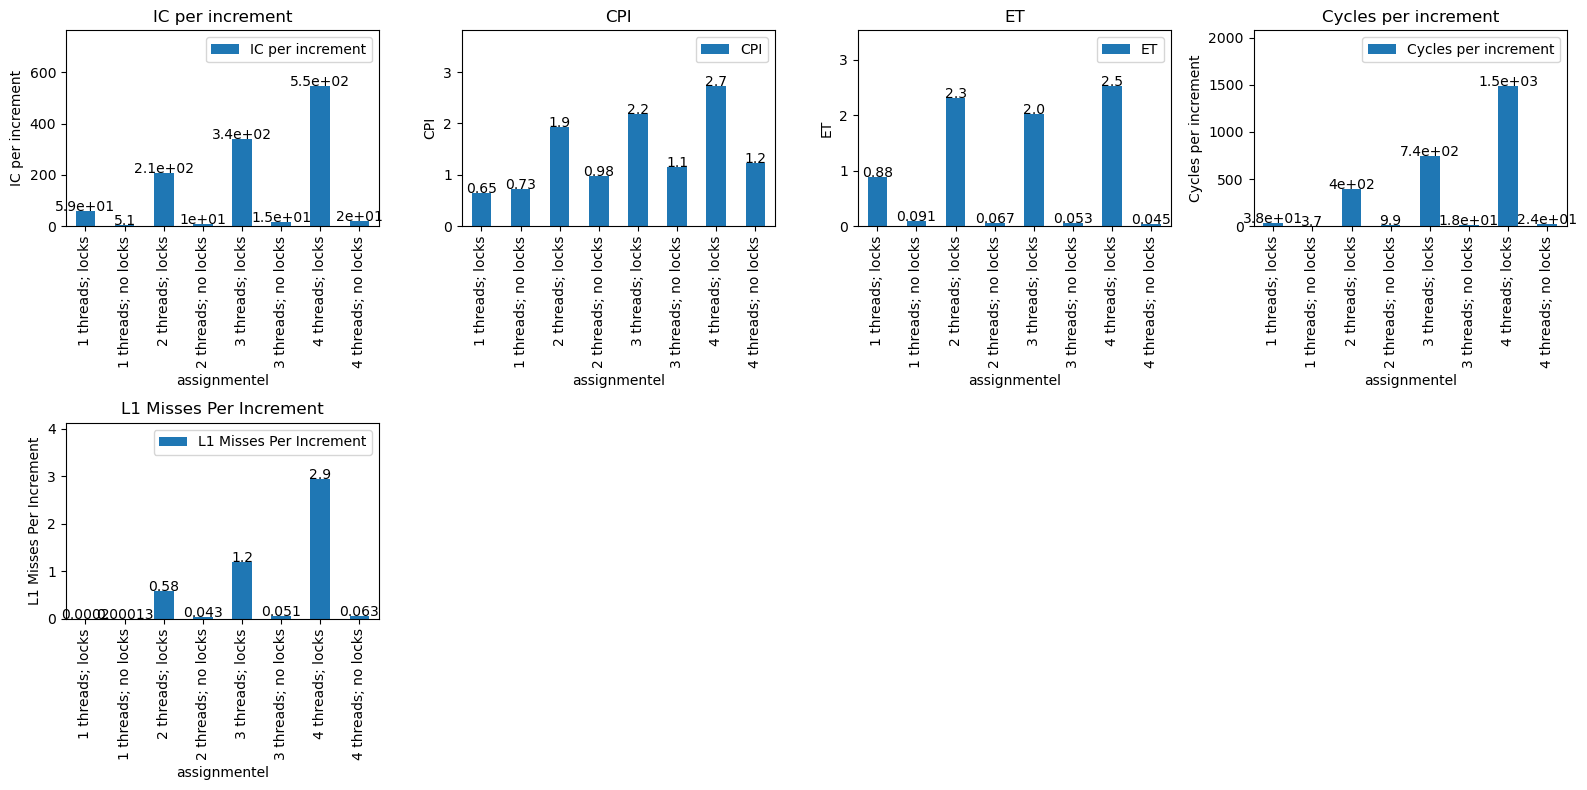

In [15]:
#key data_cell from notebook import * df = render_csv("lock_demo.csv")\ 
df["assignmentel"] = df["threads"].apply(lambda x: f"{x} threads;" ) + " " +\ 
df["arg2"].apply(lambda x: "locks" if x else "no locks") df["Total IC"] =\ 
df["IC"] * df["threads"] df["IC per increment"] =\ 
df["IC"]/(df["arg1"]/df["threads"]) df["Cycles per increment"] =\ 
df["Cycles"]/(df["arg1"]/df["threads"]) df["L1 Misses Per Increment"] =\ 
df["L1_dcache_misses"]/(df["arg1"]/df["threads"]) df["locks"] = df["arg2"]\ 
display_mono(df[["threads", "locks", "IC per increment", "CPI", "ET", "Cycles\ 
per increment", "L1 Misses Per Increment"]]) plotPEBar(df=df,\ 
what=[("assignmentel", "IC per increment"), ("assignmentel", "CPI"),\ 
("assignmentel", "ET"),  ("assignmentel", "Cycles per increment"),\ 
("assignmentel", "L1 Misses Per Increment")])

<div class="alert alert-block alert-success"> 

### Question 4 (CSE142 & CSE142L)



Answer the questions below:
    
* How much does adding locks slow down the single thread case in terms of cycles per increment? 
    
* How much does adding a second thread slow down each increment in terms of cycles per increment? 
    
* How many cycles does it take to take and release a lock? 
    
For each question, please make sure to include your calculations and clearly state the final answer in this cell. If necessary, you should use LaTeX syntax for equations and formulas. Your answers must base on the experiments above.
</div>

<div class="alert alert-block alert-success">


* How much does adding locks slow down the single thread case in terms of cycles per increment? 

No locks: $3.71$ cycles per increment

With locks: $38.44$ cycles per increment

$$ \frac{38.44}{3.71} \approx 10.36 $$

$$ Extra cycles per increment = 38.44 - 3.71 = 34.73 $$

About 10.36x slower, adding ~34.7 cycles per increment
    
* How much does adding a second thread slow down each increment in terms of cycles per increment?

With locks: 
1 thread = $38.44$ cycles, 2 threads = $397.80$ cycles

$$ \frac{397.80}{38.44} \approx 10.35 $$
    
397.80 - 38.44 = 359.36
    
Without locks: 
1 thread = $3.71$ cycles, 2 threads = $9.92$ cycles

$$ \frac{9.92}{3.71} \approx 2.68 $$
    
9.92 - 3.71 = 6.21
    
With locks, about $10.35\times$ slower per increment ($\approx 359.4$ extra cycles). Without locks, about $2.68\times$ slower ($\approx 6.2$ extra cycles).
    
* How many cycles does it take to take and release a lock? 

$$ \approx 38.44 - 3.71 = 34.73 $$

About $34.7$ cycles per uncontended lock--unlock pair.
</div>

,threads,size,arg1,this_core,other_core,arg3,IC,CPI,CT,ET,L1_dcache_miss_rate
0,1,1048576,10000000,0,0,0,1119644698,0.711665,0.390305,0.311000,0.000043
1,1,1048576,10000000,0,1,0,2031114902,2.073950,0.198585,0.836527,0.008961


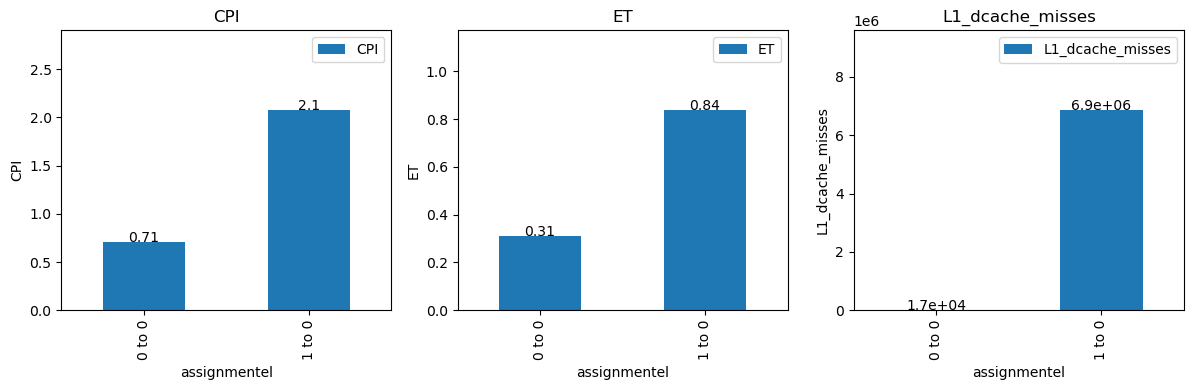

In [17]:
df = render_csv("coherence.csv") df["other_core"] = df["arg2"] df["this_core"] =\ 
df["arg3"] df["assignmentel"] = df["arg2"].astype(str) + " to " +\ 
df["arg3"].astype(str)  df["IC per increment"] = df["IC"]/df["arg1"] df["Cycles\ 
per increment"] = df["Cycles"]/df["arg1"] display_mono(df[["threads", "size",\ 
"arg1", "this_core", "other_core", "arg3", "IC", "CPI", "CT", "ET",\ 
"L1_dcache_miss_rate"]]) plotPEBar(df=df,  what=[("assignmentel", "CPI"),\ 
("assignmentel", "ET"), ("assignmentel", "L1_dcache_misses")])

,threads,size,arg1,other_core,arg3,IC,CPI,CT,ET,L1_dcache_miss_rate
0,1,1048576,10000000,0,0,89763345,0.605364,0.591044,0.032117,0.000333
1,1,1048576,10000000,1,0,100796961,0.986222,0.249718,0.024824,0.016207


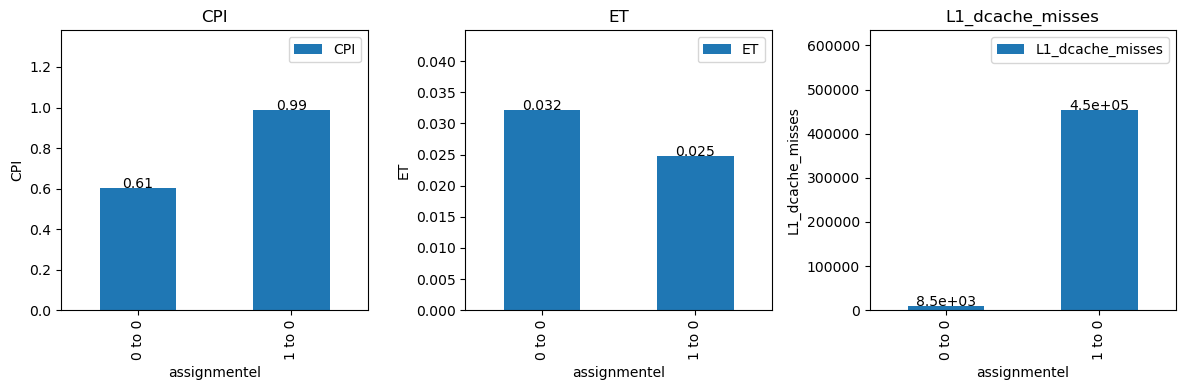

In [19]:
df = render_csv("false_sharing.csv") df["other_core"] = df["arg2"]\ 
df["this_core"] = df["arg3"] df["assignmentel"] = df["arg2"].astype(str) + " to\ 
" + df["arg3"].astype(str)  df["IC per increment"] = df["IC"]/df["arg1"]\ 
df["Cycles per increment"] = df["Cycles"]/df["arg1"] display_mono(df[["threads",\ 
"size", "arg1", "other_core", "arg3", "IC", "CPI", "CT", "ET",\ 
"L1_dcache_miss_rate"]]) plotPEBar(df=df,  what=[("assignmentel", "CPI"),\ 
("assignmentel", "ET"), ("assignmentel", "L1_dcache_misses")])

<div class="alert alert-block alert-success">


### Question 5 (CSE142 & CSE142L)    



How much difference in performance do you see between running both threads on one core vs. running them on two cores?
    

</div>

<div class="alert alert-block alert-success">   


Please make sure to include your calculations and clearly state the final answer in this cell. If necessary, you should use LaTeX syntax for equations and formulas. Your answers must base on the experiments above.

Answer:
    
$$ ET ratio = \frac{0.836527}{0.311000} \approx 2.69 $$ 

$$ CPI\ ratio = \frac{2.073950}{0.711665} \approx 2.91 $$

$$ L1\ miss\ ratio = \frac{0.008961}{0.000043} \approx 2.08 \times 10^{2} $$

Final: Running on two cores is about $2.69\times$ slower than running both threads on one core, with CPI about $2.91\times$ higher and L1 miss rate about $208\times$ higher due to cache-line ping-pong.

</div>

<div class="alert alert-block alert-warning">



### Question 6 (CSE142L Only)    



Add a single line to the code above to get the 2x performance improvement we seek. (Hint:  The memory system thinks in cache lines and so should you).
    

</div>

Done code generation...
make: 'fiddle.exe' is up to date.
make: Warning: File 'build/false_sharing_2.cpp' has modification time 24 s in the future
mkdir -p build/ 
cp *.hpp build/
cp *.h   build/
g++-9  -DHAVE_LINUX_PERF_EVENT_H -pthread -DHAVE_LINUX_PERF_EVENT_H -I/home/jut008/2025su-cse142-cse142l-parallelism-starter -g -O3 -fopenmp -lm -pthread -lboost_program_options -L/usr/lib/ -lboost_system -ldl  -rdynamic -fPIC -shared -o build/false_sharing_2.so build/false_sharing_2.cpp
make: warning:  Clock skew detected.  Your build may be incomplete.
Running on the cloud for: jut008@ucsd.edu
registering function: false_sharing_2
Dynamically registering false_sharing_2
Execution started
Execution completed


,threads,size,arg1,other_core,arg3,IC,CPI,CT,ET,L1_dcache_miss_rate
0,1,1048576,10000000,0,0,89763345,0.605364,0.591044,0.032117,0.000333
1,1,1048576,10000000,1,0,100796961,0.986222,0.249718,0.024824,0.016207
2,1,1048576,10000000,0,0,105408581,0.785080,0.384452,0.031815,0.000305
3,1,1048576,10000000,1,0,93978167,0.663600,0.296293,0.018478,0.000179


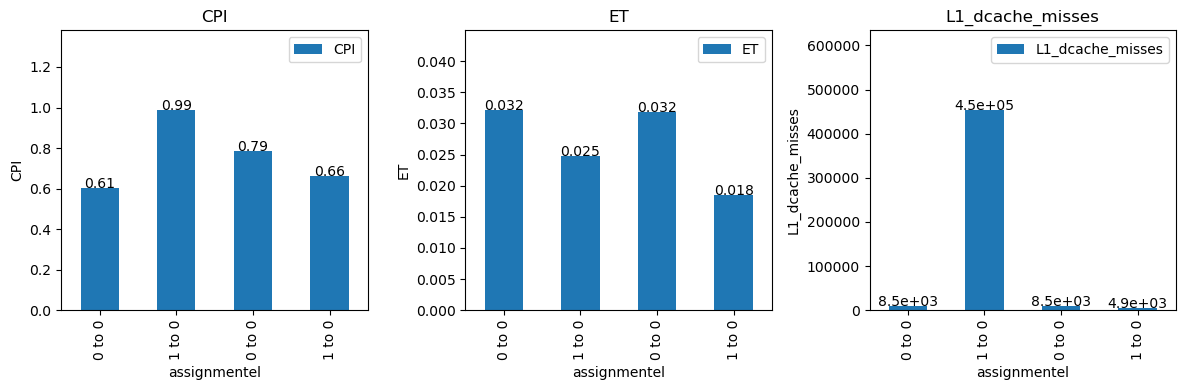

In [21]:
# Please modify the following code in "false_sharing_2" and show result!  t =\ 
fiddle("false_sharing_2.cpp", function="false_sharing_2", opt="-O3", code=r"""\ 
#include"function_map.hpp" #include<cstdint> #include<thread> #include<mutex>\ 
#include"threads.hpp" #include"pthread.h"  volatile int shared = 0; alignas(64)\ 
volatile int not_shared_0 = 0; alignas(64) volatile int not_shared_1 = 0;  void\ 
go_0(uint64_t id,int count) {     for(int i= 0; i < count; i++){\ 
not_shared_0++;     } }  void go_1(uint64_t id,int count) {     for(int i= 0; i\ 
< count; i++){         not_shared_1++;     } }  extern "C" uint64_t*\ 
false_sharing_2(uint64_t thread_count, uint64_t * data, uint64_t size, uint64_t\ 
arg1, uint64_t arg2, uint64_t arg3) {     shared = 0;     std::thread other\ 
(go_0, 1, arg1);     bind_to_core(other, arg2);\ 
bind_to_core(pthread_self(), arg3);     go_1(0, arg1);     other.join();\ 
shared = not_shared_0 + not_shared_1;     return data; }\ 
FUNCTION(one_array_2arg, false_sharing_2); """)   ! make fiddle.exe; make\ 
C_OPTS="-O3" build/false_sharing_2.so ! cse142 run "./fiddle.exe -lib\ 
./build/false_sharing_2.so -M 3700 --detail -f false_sharing_2 --arg1 10000000\ 
--arg2 0 1   --arg3 0 -o false_sharing_2.csv"\ 
df=render_csv(["false_sharing.csv","false_sharing_2.csv"]) df["other_core"] =\ 
df["arg2"] df["this_core"] = df["arg3"] df["assignmentel"] =\ 
df["arg2"].astype(str) + " to " + df["arg3"].astype(str)  df["IC per increment"]\ 
= df["IC"]/df["arg1"] df["Cycles per increment"] = df["Cycles"]/df["arg1"]\ 
display_mono(df[["threads", "size", "arg1", "other_core", "arg3", "IC", "CPI",\ 
"CT", "ET", "L1_dcache_miss_rate"]]) plotPEBar(df=df,  what=[("assignmentel",\ 
"CPI"), ("assignmentel", "ET"), ("assignmentel", "L1_dcache_misses")])

<div class="alert alert-block alert-success">


### Question 7 (CSE142 & CSE142L)    



Would this code benefit from tiling as a locality optimization?  Why or why not? 


</div>

<div class="alert alert-block alert-success">    


Answer: No, the serial histogram would not benefit from tiling. The working set that is repeatedly reused is the histogram itself, and it is tiny. With 256 buckets and 8-byte counters the array is about 2 KB, which easily fits in a 32 KB L1 data cache. Once the histogram lines are brought into L1 they are reused throughout the whole scan, so there is no capacity pressure to relieve with tiles. The data array is streamed exactly once, so its misses are mostly compulsory; tiling cannot reduce those either. The measurements back this up: the L1 miss rate is already very low (≈0.64%), and the compiler has fully unrolled the inner loop to keep the hot counters live and minimize control overhead. Adding tiling here would just add extra loop control and bookkeeping without improving locality.

Tiling could help only in different regimes, for example if the histogram had many more buckets so it no longer fit in L1, or in a parallel version where you give each thread a private histogram and combine at the end.
        
Please explain in detail to receive credits
</div>

,index,function,threads,size,arg1,arg2,arg3,IC,CPI,ET,L1_dcache_misses,L1_dcache_miss_rate,speedup,Total IC,Total cache misses
0,0,run_unthreaded_histogram,1,10000000,1,1,1,297151403,0.294694,0.040437,1138480,0.006399,1.000000,297151403,1138480
1,0,run_threaded_histogram,1,10000000,1,1,1,4807150405,0.647177,1.181753,1170734,0.000685,0.034218,4807150405,1170734
2,1,run_threaded_histogram,2,10000000,1,1,1,10891998939,2.600700,5.397466,93367606,0.022866,0.007492,21783997878,186735212
3,2,run_threaded_histogram,3,10000000,1,1,1,12233846909,2.915283,4.868391,141364882,0.030663,0.008306,36701540727,424094646
4,3,run_threaded_histogram,4,10000000,1,1,1,16403962952,3.065309,6.068484,228579446,0.036709,0.006663,65615851808,914317784
5,4,run_threaded_histogram,5,10000000,1,1,1,21171229309,3.147591,7.116848,329570166,0.040985,0.005682,105856146545,1647850830
6,5,run_threaded_histogram,6,10000000,1,1,1,25808400204,3.218593,7.896067,447483512,0.045445,0.005121,154850401224,2684901072
7,6,run_threaded_histogram,7,10000000,1,1,1,36881924661,4.020277,12.378413,694246367,0.049425,0.003267,258173472627,4859724569
8,7,run_threaded_histogram,8,10000000,1,1,1,43066070103,5.012148,15.437477,881360527,0.053967,0.002619,344528560824,7050884216


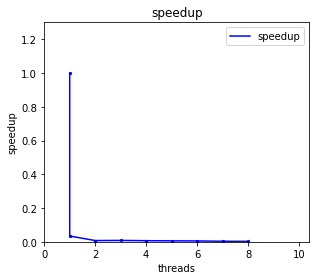

In [28]:
hist_data = render_csv(["histogram_unthreaded.csv", "histogram_threaded.csv"],\ 
columns=hist_columns) hist_data["speedup"] =\ 
hist_data.iloc[0]["ET"]/hist_data["ET"] hist_data["Total IC"] =\ 
hist_data["IC"]*hist_data["threads"] hist_data["Total cache misses"] =\ 
hist_data["L1_dcache_misses"]*hist_data["threads"] display(hist_data)\ 
plotPE(df=hist_data, lines=True, what=[("threads", "speedup")])

<div class="alert alert-block alert-success">

    
### Question 8 (CSE142 & CSE142L)


How much speedup do you observe with 4 threads? Why?


</div>

<div class="alert alert-block alert-success">    
<div class="answer">
[Please include your calculations in addition to the numerical result. Your answer should come from the experiment above and should include LaTeX forumla if necessary.]

**Speedup:** 
$$ Speedup = \frac{ET_{1}}{ET_{4}} = \frac{0.040437}{6.068484} \approx 0.00666 $$
**Why:**

Each increment takes a global mutex. The critical section is tiny but executed for every byte of every element, so all threads serialize on the same lock. That creates heavy contention and lock convoying, adds large instruction overhead from lock and unlock, and causes coherence traffic as the cache line holding the lock and hot histogram buckets ping-pong between cores. You can see the effects in the counters: ET balloons to 6.07s and CPI rises to 3.07, with the L1 miss rate increasing to 0.0367. A better design is to avoid the shared lock by using per-thread private histograms and combining at the end.
        
</div>
</div>

<div class="alert alert-block alert-warning">


### Question 9 (CSE142L Only)    



What causes the drop in performance from 1 thread to 2?  How can we fix it?
    
</div>

<div class="alert alert-block alert-warning">    

[Be sure to provide good enough guess explaination even though this is a completeness one.]

Answer: The performance drop from 1 to 2 threads is caused by false sharing in the private-bucket array. In the current layout, for a given bucket value all threads update adjacent memory locations, which end up on the same cache line. This causes the cache line to constantly ping-pong between cores, leading to a huge increase in L1 misses and CPI when more than one thread is active. The fix is to reorganize the array so that each thread’s set of 256 counters is in a separate region of memory, aligned and padded so they do not share cache lines. With this change, threads update disjoint memory locations and avoid false sharing, allowing performance to scale as intended when moving from 1 to multiple threads.
    
    

        
</div>

<div class="alert alert-block alert-info">


### Question 10 (CSE142 Only) 



What is $x$ for parallel merge sort?  Can you bound speedup for 4 processors, a threshold of 1024, and a total array size of 4096?  If you can't get a precise answer try to estimate or provide an upper bound the value of $x$.
    
</div>


<div class="alert alert-block alert-info">  


Please observe the above code and explain/justify your estimation.

Answer: For parallel merge sort, almost all work is parallel except the final full-array merge. The serial fraction for N = 4096 is

$$ Serial\ Fraction = \frac{1}{\log_{2} 4096} = \frac{1}{12} \approx 0.083 $$

so the parallel fraction is

$$ x = 1 - 0.083 \approx 0.917 $$

and the Amdahl bound for four processors is

$$ S \le \frac{1}{(1 - x) + \frac{x}{4}} = \frac{1}{0.083 + 0.917/4} \approx 3.2 $$

So with four processors the best achievable speedup is about 3.2× rather than 4×.

        
</div>

<div class="alert alert-block alert-warning">


### Question 11 (CSE142L Only) 

On Linux, you can use the command `taskset -c list_of_available_cores` to restrict the scheduling policy to allocate your threads on the given set of processors. Can you modified the cell below and find out what's the best list that can deliver the best performance for the runing the histogram program with 4 threads?
    
Remember that we have 36 logical processors. So the list should only has numbers from 0 to 71.
    
</div>


In [45]:
# Please run your experiments below using `taskset` command to find out the 4\ 
! cse142 run "taskset -c 0,1,18,19 ./fiddle.exe -lib ./build/histogram.so -M\ 
3700 --detail -f run_private2_histogram --size 10000000 --threads 4 -o\ 
histogram_taskset.csv" ! cse142 run "taskset -c 0,1,2,3 ./fiddle.exe -lib\ 
./build/histogram.so -M 3700 --detail -f run_private2_histogram --size 10000000\ 
--threads 4 -o histogram_taskset_2.csv"\ 
display_mono(render_csv(["histogram_taskset.csv","histogram_taskset_2.csv"]))

Running on the cloud for: jut008@ucsd.edu
registering function: run_unthreaded_histogram
registering function: run_threaded_histogram
registering function: run_fine_locks_histogram
registering function: run_private_histogram
registering function: run_private2_histogram
registering function: run_openmp_histogram
registering function: run_openmp_private_histogram
Dynamically registering run_fine_locks_histogram
Dynamically registering run_openmp_histogram
Dynamically registering run_openmp_private_histogram
Dynamically registering run_private2_histogram
Dynamically registering run_private_histogram
Dynamically registering run_threaded_histogram
Dynamically registering run_unthreaded_histogram
Execution started
Execution completed
Running on the cloud for: jut008@ucsd.edu
registering function: run_unthreaded_histogram
registering function: run_threaded_histogram
registering function: run_fine_locks_histogram
registering function: run_private_histogram
registering function: run_private2_hi

,index,reps,size,size2,threads,arg1,arg2,arg3,function,IC,Cycles,CPI,CT,ET,L1_dcache_miss_rate,L1_dcache_misses,L1_dcache_accesses,branches,branch_misses
0,0,1,10000000,16384,4,1,1,1,run_private2_histogram,321315181,282642102,0.879641,0.199447,0.056372,0.009874,1734224,175633507,5639,9283056
1,0,1,10000000,16384,4,1,1,1,run_private2_histogram,337474630,371899751,1.102008,0.136187,0.050648,0.028893,5206367,180191828,6027,8662575


<div class="alert alert-block alert-warning">  


Please observe the above experiments that you modified and discuss what's the best combination.

Answer: 0,1,2,3

        
</div>